In [7]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics, linear_model, preprocessing, svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy

#samples =2428
samples = 300
seed = 244828
time_multiplicator = 1

X, y =  datasets.make_classification(n_features=2, n_redundant=0, class_sep=2, n_clusters_per_class=1, random_state=seed,n_samples=samples)
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.8,test_size=0.2, random_state=seed)


def normalize(matrix):
    return (matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))

def standarize(matrix):
    return (matrix - np.mean(matrix))/(np.std(matrix))

X_train = normalize(X_train)
X_test = normalize(X_test)

y_train[y_train == 0] =-1
y_test[y_test == 0] =-1

In [19]:
class mySVM:
    def __init__(self, C=1.0, sigma=0.1, degree=2):
        self.C = C
        self.kernel = self.polynomial
        self.degree = 1
        self.X = None
        self.y = None
        self.alpha = None
        self.b = 0
        self.ones = None
        self.y_iy_jk_ij=None

    def polynomial(self, X1, X2):
        return (1 + X1.dot(X2.T)) ** self.degree
    
    def cost(self, x):
        return -(np.sum(x) - 0.5 * np.sum(np.outer(x, x) * self.y_iy_jk_ij))
    
    def fit(self, X, y, lr=2e-4, epochs=500):
        self.X = X
        self.y = y

        self.alpha = np.random.random(X.shape[0])
        self.b = 0
        
        self.ones = np.ones(X.shape[0])

        self.y_iy_jk_ij = np.outer(y, y) * self.kernel(X, X)

        losses = []
        
        res = scipy.optimize.fmin_cg(self.cost, self.alpha)
        self.alpha = res

        index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]

        b_i = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))

        self.b = np.mean(b_i)

    def decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b
    
    def predict(self, X):
        return np.sign(self.decision_function(X))

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)

In [20]:
def compare_model(sk, my,X_tr, X_te, y_tr, y_te ):
    sk_time = time.perf_counter()
    for i in range(time_multiplicator):
        sk.fit(X_tr,y_tr)
    sk_time = (time.perf_counter() - sk_time)/time_multiplicator

    my_time = time.perf_counter()
    for i in range(time_multiplicator):
        my.fit(X_tr,y_tr)
    my_time = (time.perf_counter() - my_time)/time_multiplicator
    
    my_pred = my.predict(X_te)
    sk_pred = sk.predict(X_te)
    
    #graph
    fig, axs = plt.subplots(3, 2,figsize=(12,18))

    mesh = np.meshgrid(np.arange(0, 1.1, 0.01), np.arange(0, 1.1, 0.01))[0]
    sk_predict = sk.predict(np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)
    my_predict = np.array(my.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)
    
    axs[0,0].set_title("Sklearn")
    axs[0,0].contourf(mesh, mesh.T, sk_predict, alpha=0.2)
    axs[0,0].scatter(X_te[:, 0], X_te[:, 1], c=y_te, marker="o", alpha=0.5)
    axs[0,0].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, marker="+", alpha=0.2)

    axs[0,1].set_title("Własna implementacja")
    axs[0,1].contourf(mesh, mesh.T, my_predict, alpha=0.2)
    axs[0,1].scatter(X_te[:, 0], X_te[:, 1], c=y_te, marker="o", alpha=0.5)
    axs[0,1].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, marker="+", alpha=0.2)
    
    #confusion matrix
    sk_cm = metrics.confusion_matrix(y_te, sk_pred)
    sk_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=sk_cm)
    sk_disp.plot(ax=axs[1,0])
    sk_disp.im_.colorbar.remove()

    my_cm = metrics.confusion_matrix(y_te, my_pred)
    my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
    my_disp.plot(ax=axs[1,1])
    my_disp.im_.colorbar.remove()
    my_disp.ax_.set_ylabel('')

    #roc
    fpr, tpr, thresholds = metrics.roc_curve(y_te, sk.decision_function(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Sklearn')
    display.plot(ax=axs[2,0])

    fpr, tpr, thresholds = metrics.roc_curve(y_te, my.decision_function(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='własna implementacja')
    display.plot(ax=axs[2,1])
    
    print('              | Sklearn | Własna')
    print(f'Czułość       |{sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0]):9.4f}|{my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]):.4f}')
    print(f'Specyficzność |{sk_cm[1][1]/(sk_cm[0][0]+sk_cm[1][1]):9.4f}|{my_cm[1][1]/(my_cm[0][0]+my_cm[1][1]):.4f}')
    print(f'Skuteczność   |{metrics.accuracy_score(sk_pred, y_test):9.4f}|{metrics.accuracy_score(my_pred, y_test):.4f}')
    print(f'Czas wykonania|{sk_time:9.2E}|{my_time:.2E}')
    print(f'BACC          |{metrics.balanced_accuracy_score(sk_pred, y_test,adjusted=False):9.4f}|{metrics.balanced_accuracy_score(my_pred, y_test,adjusted=False):.4f}')

In [21]:
moons, moons_c = datasets.make_moons(n_samples=samples, noise = 0.1, random_state=seed)

M_train, M_test, mc_train, mc_test = train_test_split(moons, moons_c, test_size=0.2, random_state=0)
mc_train[mc_train == 0] =-1
mc_test[mc_test == 0] =-1
M_train = normalize(M_train)
M_test = normalize(M_test)

# Modele liniowe

         Current function value: -48515.734796
         Iterations: 264
         Function evaluations: 162686
         Gradient evaluations: 675
              | Sklearn | Własna
Czułość       |   1.0000|1.0000
Specyficzność |   0.5333|0.5424
Skuteczność   |   1.0000|0.9833
Czas wykonania| 4.24E-03|4.83E+01
BACC          |   1.0000|0.9848


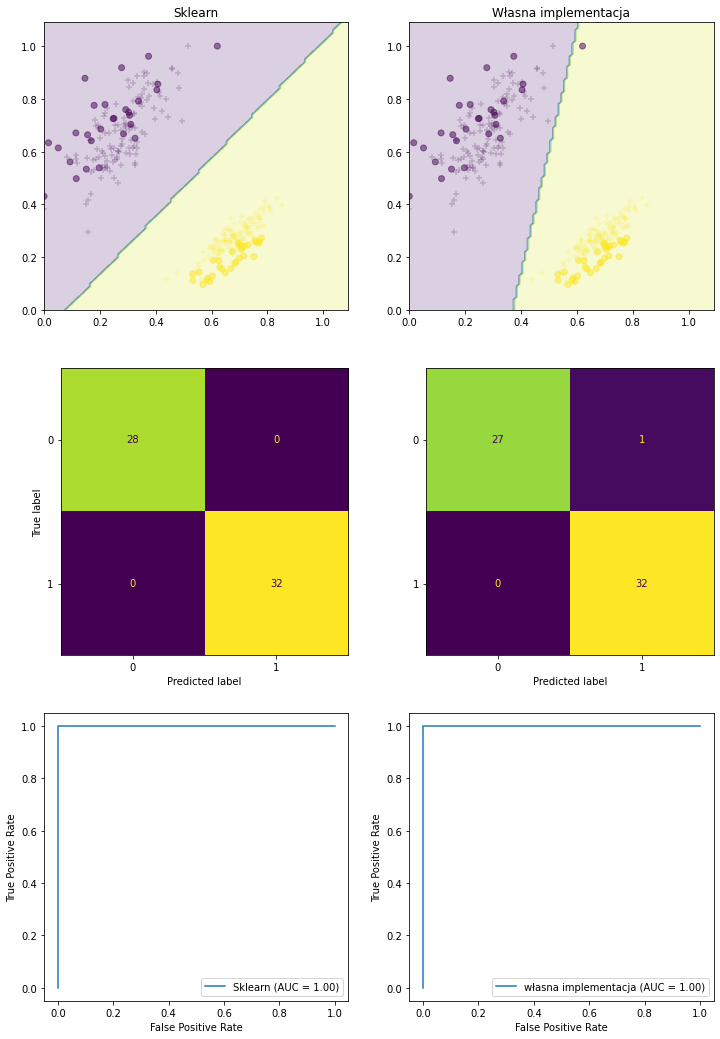

In [22]:
my11 = mySVM(C=0.5)
sk11 = svm.SVC(kernel='linear')
compare_model(sk11, my11,X_train, X_test, y_train, y_test)

         Current function value: -209885.729908
         Iterations: 172
         Function evaluations: 116660
         Gradient evaluations: 484
              | Sklearn | Własna
Czułość       |   0.8333|0.8387
Specyficzność |   0.5000|0.4902
Skuteczność   |   0.5333|0.5167
Czas wykonania| 7.95E-03|3.62E+01
BACC          |   0.5333|0.5178


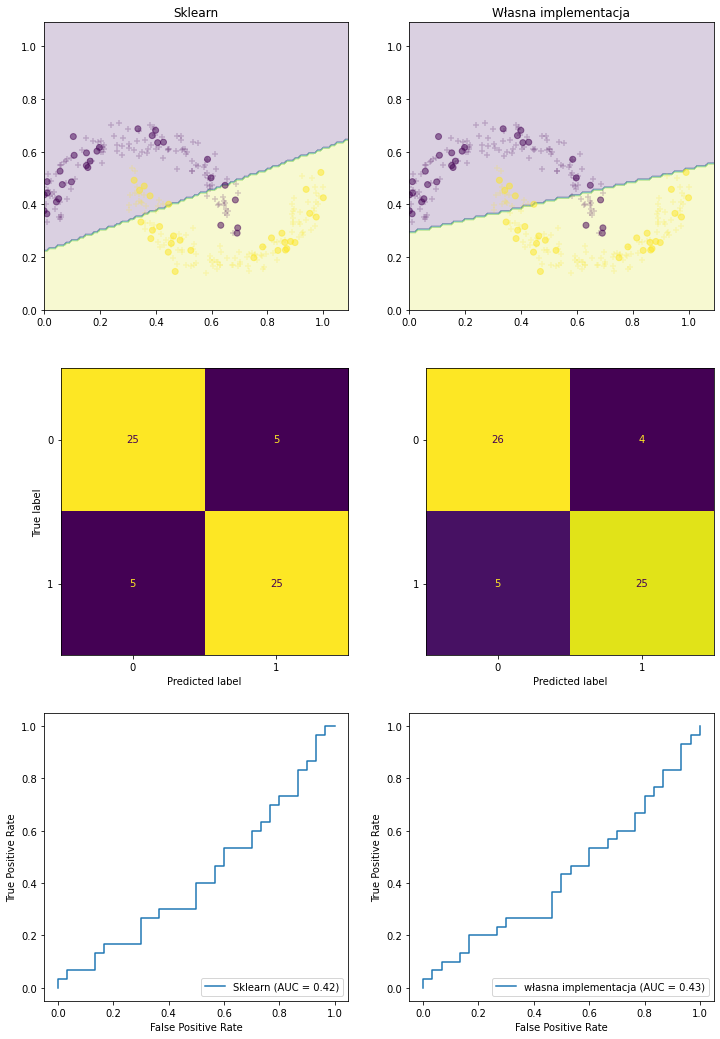

In [23]:
my12 = mySVM(C=0.5)
sk12 = svm.SVC(kernel='linear')
compare_model(sk12, my12,M_train, M_test, mc_train, mc_test)